In [ ]:
import pandas as pd

path = 'SAMPLE_DATA_SET.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])


INPUT DATA

In [ ]:
X =df.get(0)
X = (X.iloc[:,1:]).values
X = X.T
print(X.shape)

(839, 444)


OUTPUT DATA

In [ ]:
Y =df.get(1)
Y = (Y.iloc[:,:]).values
print(Y.shape)

(839, 2)


RIDGE REGRESSION with closed form solution

In [ ]:
a1 = 0.01
a2 = 0.001

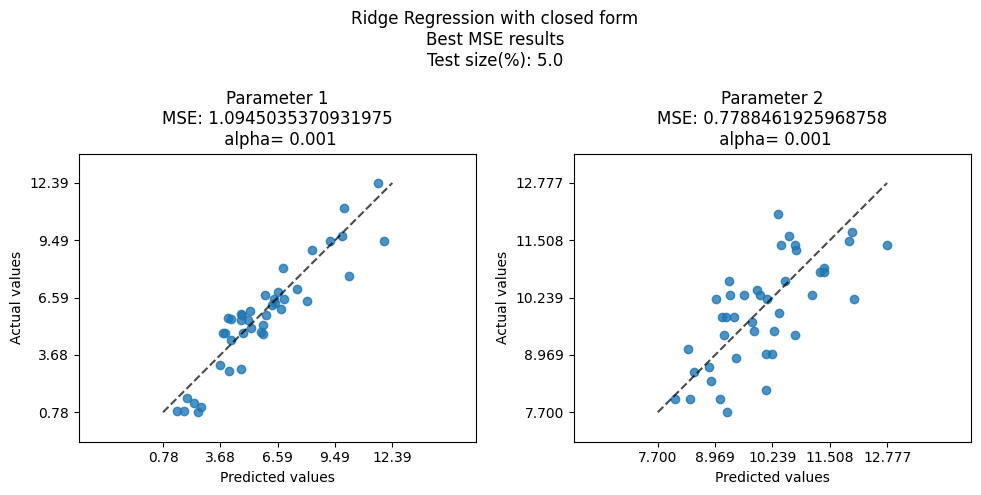

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge
from tabulate import tabulate

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  #["Ripartition", "Best_MSE1", "Best_MSE2","MSE1_mean","MSE2_mean","MSE1_var","MSE2_var","alpha1","alpha2"]


for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None}

    i = 0
    for i in range(trials):
        #Ripartition in training and test and
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
        param_grid = {'alpha': [i/100000 for i in range(1,10001,1)]}
        ridge_reg_cl = Ridge(solver="cholesky")

        grid_search = GridSearchCV(ridge_reg_cl, param_grid, scoring='neg_mean_squared_error')

        #grid search will contain the best model
        grid_search.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_ridge_cl =  grid_search.predict(X_test)

        #save MSE of the first parameters
        MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_cl))

        #check if this is the best model in terms of MSE
        if MSE_param1[-1] < best_MSE_1:
          best_MSE_1 = MSE_param1[-1]
          best_data_1["Y_test"] = Y_test
          best_data_1["Y_pred"] = Y_pred_ridge_cl
          best_data_1["alpha"] =  float(grid_search.best_params_["alpha"])


    '''PARAM 2'''
    MSE_param2 = []

    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None,"alpha":None}

    i = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
        param_grid = {'alpha': [i/100000 for i in range(1,10001,1)]}
        ridge_reg_cl = Ridge(solver="cholesky")

        grid_search = GridSearchCV(ridge_reg_cl, param_grid, scoring='neg_mean_squared_error')

        #grid search will contain the best model
        grid_search.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_ridge_cl = grid_search.predict(X_test)

        #save MSE of the second parameters
        MSE_param2.append(mean_squared_error(Y_test, Y_pred_ridge_cl))

        #check if this is the best model in terms of MSE
        if MSE_param2[-1] < best_MSE_2:
          best_MSE_2 = MSE_param2[-1]
          best_data_2["Y_test"] = Y_test
          best_data_2["Y_pred"] = Y_pred_ridge_cl
          best_data_2["alpha"] =  float(grid_search.best_params_["alpha"])


    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
     (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)), str(np.var(MSE_param2)), str(best_data_1["alpha"]), str(best_data_2["alpha"])])

    '''PLOT THE BEST MODELS'''
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.3)
    PredictionErrorDisplay.from_predictions(y_true=best_data_1["Y_test"], y_pred=best_data_1["Y_pred"], kind = "actual_vs_predicted", ax=axs[0])
    axs[0].set_title("Parameter 1"+"\n"+ "MSE: " +  str(min(MSE_param1)) + "\n" + " alpha= "+ str(best_data_1["alpha"]))
    disp2= PredictionErrorDisplay.from_predictions(y_true=best_data_2["Y_test"], y_pred=best_data_2["Y_pred"], kind = "actual_vs_predicted", ax=axs[1])
    axs[1].set_title("Parameter 2"+"\n"+ "MSE: " +  str(min(MSE_param2)) + "\n" + " alpha= "+ str(best_data_2["alpha"]))
    fig.suptitle("Ridge Regression with closed form"+"\n"+ "Best MSE results" + "\n"+ f"Test size(%): {ripartition * 100}")
    plt.tight_layout()
    plt.show()


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","alpha1","alpha2"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD**

In [ ]:
from sklearn.linear_model import SGDRegressor

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  #["Ripartition", "Best_MSE1", "Best_MSE2","MSE1_mean","MSE2_mean","MSE1_var","MSE2_var","alpha1","alpha2"]


for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None}

    i = 0
    for i in range(trials):
        #Ripartition in training and test and
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
        param_grid = {'alpha': [i/100000 for i in range(1,10001,1)]}
        ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                            n_iter_no_change=10, random_state=42)

        grid_search = GridSearchCV(ridge_reg_sgd, param_grid, scoring='neg_mean_squared_error')

        #grid search will contain the best model
        grid_search.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_ridge_sgd =  grid_search.predict(X_test)

        #save MSE of the first parameters
        MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))

        #check if this is the best model in terms of MSE
        if MSE_param1[-1] < best_MSE_1:
          best_MSE_1 = MSE_param1[-1]
          best_data_1["Y_test"] = Y_test
          best_data_1["Y_pred"] = Y_pred_ridge_sgd
          best_data_1["alpha"] =  float(grid_search.best_params_["alpha"])


    '''PARAM 2'''
    MSE_param2 = []

    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None,"alpha":None}

    i = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
        param_grid = {'alpha': [i/100000 for i in range(1,10001,1)]}
        ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, eta0=0.01,
                                            n_iter_no_change=10, random_state=42)

        grid_search = GridSearchCV(ridge_reg_sgd, param_grid, scoring='neg_mean_squared_error')

        #grid search will contain the best model
        grid_search.fit(X_train, Y_train)

        # Make predictions using the testing set
        Y_pred_ridge_sgd = grid_search.predict(X_test)

        #save MSE of the second parameters
        MSE_param2.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))

        #check if this is the best model in terms of MSE
        if MSE_param2[-1] < best_MSE_2:
          best_MSE_2 = MSE_param2[-1]
          best_data_2["Y_test"] = Y_test
          best_data_2["Y_pred"] = Y_pred_ridge_sgd
          best_data_2["alpha"] =  float(grid_search.best_params_["alpha"])

    results.append([str(ripartition *100 ), str(best_MSE_1), str(best_MSE_2),
     (np.mean(MSE_param1)),str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)),str(best_data_1["alpha"]),str(best_data_2["alpha"])])

    '''PLOT THE BEST MODELS'''
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    plt.subplots_adjust(wspace=0.3)
    PredictionErrorDisplay.from_predictions(y_true=best_data_1["Y_test"], y_pred=best_data_1["Y_pred"], kind = "actual_vs_predicted", ax=axs[0])
    axs[0].set_title("Parameter 1"+"\n"+ "MSE: " +  str(min(MSE_param1)) + "\n" + " alpha= "+ str(best_data_1["alpha"]))
    disp2= PredictionErrorDisplay.from_predictions(y_true=best_data_2["Y_test"], y_pred=best_data_2["Y_pred"], kind = "actual_vs_predicted", ax=axs[1])
    axs[1].set_title("Parameter 2"+"\n"+ "MSE: " +  str(min(MSE_param2)) + "\n" + " alpha= "+ str(best_data_2["alpha"]))
    fig.suptitle("Ridge Regression with SGD"+"\n"+ "Best MSE results" + "\n"+ f"Test size(%): {ripartition * 100}")
    plt.tight_layout()
    plt.show()


'''SHOW RESULTS'''
headers = ["Test size(%)","Best(MSE1)", "Best(MSE2)","Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","alpha1","alpha2"]

print(tabulate(results, headers,  tablefmt="double_outline"))

